# 00.Importing Libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from math import sqrt
from matplotlib import pyplot
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 01.Helpers

## 01.01 Constants

In [27]:
features = ['date', 'hospitalizations', 'heat_index', 'heat_index_sum', 'heat_index_std', 'heat_index99','heat_index95', 'temperature_mean', 'temperature_max',
           'temperature_min', 'wind_speed_mean', 'humidity_mean','lag_heat_index_1', 'lag_heat_index_2', 'lag_heat_index_3']

In [28]:
test_start_date = "2017-01-01"

## 01.02 Functions

In [29]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [30]:
def train_test_split(df, test_date, target_variable):
    # separação por tempo
    df_train = df[df.index < test_date]
    df_test  = df[df.index >= test_date]

    # remoção da variável target
    y_train = df_train[target_variable]
    y_test  = df_test[target_variable]

    df_train = df_train.drop(columns=target_variable).copy()
    df_test  = df_test.drop(columns=target_variable).copy()

    print(df_train.shape, y_train.shape)
    print(df_test.shape, y_test.shape)

    return df_train, df_test, y_train, y_test

In [31]:
def data_normalization(df_train, df_test, y_train, y_test):
    # Para as features
    scaler               = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled      = scaler.fit_transform(df_train)
    df_test_scaled       = scaler.transform(df_test)

    # Para a variável alvo
    scaler_target       = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled      = scaler_target.fit_transform(y_train.to_frame())
    y_test_scaled       = scaler_target.transform(y_test.to_frame())

    print(df_train_scaled.shape, y_train_scaled.shape)
    print(df_test_scaled.shape, y_test_scaled.shape)

    return scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled

In [32]:
def data_reconversion(scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled, y_pred):
    df_train_original = scaler.inverse_transform(df_train_scaled)
    df_test_original = scaler.inverse_transform(df_test_scaled)

    y_train_original = scaler_target.inverse_transform(y_train_scaled)
    y_test_original = scaler_target.inverse_transform(y_test_scaled)
    y_pred_original = scaler_target.inverse_transform(y_pred)

    return df_train_original, df_test_original, y_train_original, y_test_original, y_pred_original

In [33]:
def metrics(y, predicted):
    mae = mean_absolute_error(y, predicted)
    mse = mean_squared_error(y, predicted)
    rmse = mean_squared_error(y, predicted)
    mape = np.mean(np.abs((y - predicted) / y)) * 100
    r2 = r2_score(y, predicted)
    return mae, mse, rmse, mape, r2

def print_metrics(y, predicted):
    mae, mse, rmse, mape, r2 = metrics(y, predicted)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-Squared (R²): {r2:.2f}")

In [34]:
def build_model(hp):
    model = Sequential()
    # LSTM layers with variable number of units
    model.add(LSTM(units=hp.Int('units_layer1', min_value=10, max_value=100, step=5), return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(units=hp.Int('units_layer2', min_value=10, max_value=100, step=5), return_sequences=True))
    model.add(LSTM(units=hp.Int('units_layer3', min_value=10, max_value=100, step=5)))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model

# 02.Importing Datasets

In [35]:
dataset = pd.read_csv('../Preprocessing/dataset.csv', 
                   header=0, 
                   index_col=0,
                   usecols=features)

dataset

,hospitalizations,heat_index,heat_index_sum,heat_index_std,heat_index99,heat_index95,temperature_mean,temperature_max,temperature_min,wind_speed_mean,humidity_mean,lag_heat_index_1,lag_heat_index_2,lag_heat_index_3
date,,,,,,,,,,,,,,
2000-12-01,4266.0,24.154261,17970.77,4.999719,37.8966,33.5380,23.575000,35.4,13.4,1.826613,70.836022,21.132403,19.318992,15.300694
2001-01-01,4032.0,26.316156,19579.22,4.452698,37.8471,34.6685,25.136962,35.4,17.0,1.777016,75.375000,24.154261,21.132403,19.318992
2001-02-01,3888.0,27.119464,18224.28,4.274063,37.7548,35.3940,25.691071,34.2,20.2,1.916518,76.424107,26.316156,24.154261,21.132403
2001-03-01,3658.0,26.113387,19428.36,4.220196,36.7670,34.4155,24.985349,34.4,16.3,1.629704,76.383065,27.119464,26.316156,24.154261
2001-04-01,4022.0,21.383903,15396.41,3.427034,31.0030,28.0215,21.038333,30.8,11.9,1.455139,81.152778,26.113387,27.119464,26.316156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,3172.0,16.708185,12430.89,5.357643,33.1822,27.3330,16.684946,32.5,7.1,1.345027,85.837366,22.136556,25.621075,27.636221
2024-06-01,3640.0,17.283889,12444.40,5.390826,29.7834,26.8025,17.371111,31.5,4.6,1.265139,80.636111,16.708185,22.136556,25.621075
2024-07-01,3689.0,13.313495,9905.24,4.740495,26.8167,21.7780,13.736022,28.9,3.4,1.123387,81.887097,17.283889,16.708185,22.136556


In [36]:
dataset.shape

(286, 14)

# 03.Preprocessing

## 03.01 Remoção ano 2000

In [37]:
dataset = dataset[dataset.index < "2020-01-01"]

test_start_date = '2017-01-01'

# 04.Model training

## 04.01 Split train and test

In [38]:
df_train, df_test, y_train, y_test = train_test_split(dataset, test_start_date, 'hospitalizations')

(193, 13) (193,)
(36, 13) (36,)


## 04.02 Normalization

In [39]:
scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled = data_normalization(df_train, df_test, y_train, y_test)

(193, 13) (193, 1)
(36, 13) (36, 1)


## 04.03 Grouping columns 

In [40]:
# df_train_scaled = np.hstack((df_train_scaled, y_train_scaled.reshape(-1, 1)))
# df_test_scaled = np.hstack((df_test_scaled, y_test_scaled.reshape(-1, 1)))

## 04.04 Reshape input to be 3D [samples, timesteps, features]

In [41]:
# reshape input to be 3D [samples, timesteps, features]
train_X = df_train_scaled.reshape((df_train_scaled.shape[0], 1, df_train_scaled.shape[1]))
test_X = df_test_scaled.reshape((df_test_scaled.shape[0], 1, df_test_scaled.shape[1]))

print(train_X.shape, y_train_scaled.shape, test_X.shape, y_test_scaled.shape)

(193, 1, 13) (193, 1) (36, 1, 13) (36, 1)


## 04.05 Recurrent network

In [42]:
# Configurar o Random Search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,  # Número de combinações a serem testadas
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Realizar a busca
tuner.search(train_X, y_train_scaled, epochs=50, validation_data=(test_X, y_test_scaled), callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Better number of LSTM units in the first layer: {best_hps.get('units_layer1')}")
print(f"Better number of LSTM units in the second layer: {best_hps.get('units_layer2')}")
print(f"Better number of LSTM units in the third layer: {best_hps.get('units_layer3')}")
print(f"Melhor taxa de aprendizado: {best_hps.get('learning_rate')}")

Reloading Tuner from my_dir/lstm_tuning/tuner0.json
Better number of LSTM units in the first layer: 20
Better number of LSTM units in the second layer: 50
Better number of LSTM units in the third layer: 20
Melhor taxa de aprendizado: 0.01


Epoch 1/150


/home/thiery/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 - 4s - 263ms/step - loss: 0.1404 - val_loss: 0.0116
Epoch 2/150
17/17 - 0s - 7ms/step - loss: 0.0772 - val_loss: 0.0277
Epoch 3/150
17/17 - 0s - 7ms/step - loss: 0.0432 - val_loss: 0.0205
Epoch 4/150
17/17 - 0s - 8ms/step - loss: 0.0427 - val_loss: 0.0242
Epoch 5/150
17/17 - 0s - 6ms/step - loss: 0.0418 - val_loss: 0.0265
Epoch 6/150
17/17 - 0s - 6ms/step - loss: 0.0390 - val_loss: 0.0246
Epoch 7/150
17/17 - 0s - 6ms/step - loss: 0.0402 - val_loss: 0.0256
Epoch 8/150
17/17 - 0s - 6ms/step - loss: 0.0393 - val_loss: 0.0248
Epoch 9/150
17/17 - 0s - 6ms/step - loss: 0.0393 - val_loss: 0.0244
Epoch 10/150
17/17 - 0s - 8ms/step - loss: 0.0391 - val_loss: 0.0235
Epoch 11/150
17/17 - 0s - 7ms/step - loss: 0.0390 - val_loss: 0.0226
Epoch 12/150
17/17 - 0s - 7ms/step - loss: 0.0388 - val_loss: 0.0218
Epoch 13/150
17/17 - 0s - 6ms/step - loss: 0.0385 - val_loss: 0.0212
Epoch 14/150
17/17 - 0s - 6ms/step - loss: 0.0382 - val_loss: 0.0207
Epoch 15/150
17/17 - 0s - 6ms/step - loss: 0.0378 - v

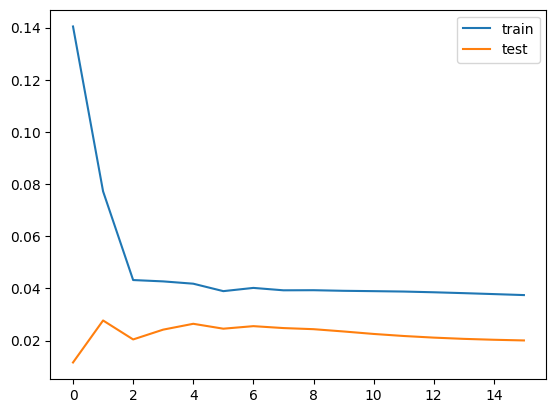

In [43]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

optimizer = Adam(learning_rate=0.01)

# design network
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(20))
model.add(Dense(1))
model.compile(loss='mse', optimizer=optimizer)

# fit network
history = model.fit(train_X, 
                    y_train_scaled, 
                    epochs=150, 
                    batch_size=12, 
                    validation_data=(test_X, y_test_scaled), 
                    verbose=2, 
                    callbacks=[early_stopping],
                    shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1, 20)          │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 50)          │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,865 (265.10 KB)

 Trainable params: 22,621 (88.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,244 (176.74 KB)

### 04.05.01 Prediction

In [45]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler_target.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = y_test_scaled.reshape((len(y_test_scaled), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler_target.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
print_metrics(inv_y, inv_yhat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step
Mean Absolute Error (MAE): 189.00
Mean Squared Error (MSE): 51300.87
Root Mean Squared Error (RMSE): 51300.87
Mean Absolute Percentage Error (MAPE): 5.69%
R-Squared (R²): -0.30


### 04.05.02 Plot

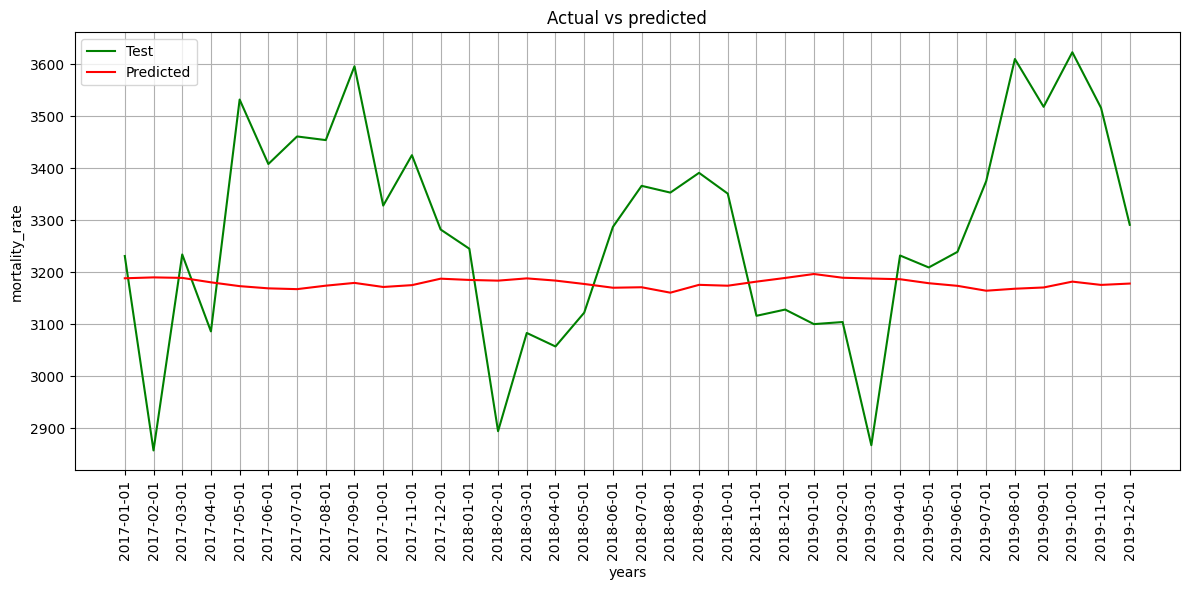

In [46]:
index_train = pd.to_datetime(dataset.index)
index_test = dataset.tail(36).index

plt.figure(figsize=(12, 6))
# plt.plot(index_train, dataset['hospitalizations'], color='green', label='Train')
plt.plot(index_test, inv_y, color='green', label='Test')
plt.plot(index_test, inv_yhat, color='red', label='Predicted')
plt.title("Actual vs predicted")
plt.xlabel('years')
plt.ylabel('mortality_rate')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()